# Part 1

This notebook should contain the solution to part 1 of the assessment.

Below is the 'nearly' complete FWI algorithm - only the value of $\alpha$ is missing.

In [19]:
# This cell contains the various imports we will need
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver

from devito import configuration
configuration['log-level'] = 'WARNING'

%matplotlib inline


### Load a subset of the Marmousi velocity model

We choose our $v_p$ model to have a size of 401x201 (instead of the full 1601x401 contained in the original data file) to save computational cost. We smooth the original/true model $v_p$ and save the smoothed model in `model0` as an initial velocity model for FWI. We also set the model spacing to be `dx=dz=10m`, with origin `x0=z0=0`, and padding boundary `nbl=10`. The plots below shows true & smooth models, and their difference.

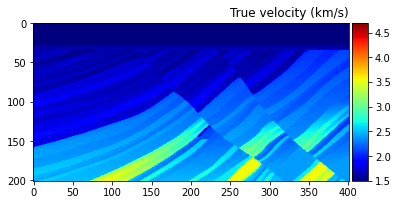

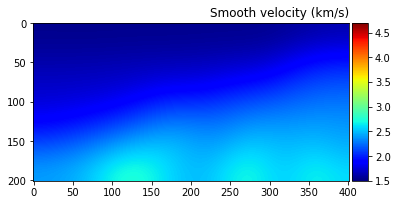

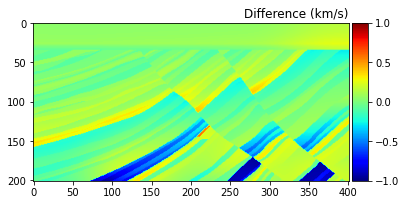

In [20]:
#Load 2D Marmousi velocity model, update the path of 'vp_marmousi_bi' as needed
v = np.fromfile('vp_marmousi_bi', dtype='float32', sep="")

#Velocity model dimension
shape = (1601, 401)
spacing = (10., 10.)
origin = (0., 0.)
nbl = 10
v = v.reshape(shape)

#Cut velocity model size from (1601,401) to (401,201)
v = v[600:-600, :201]

# Gaussian smoothing of the true velocity model
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)

#True Vp model
model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
              shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

#Smooth/Initial Vp model
model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
               shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

#Plot true & smooth Vp models, and their difference
from examples.seismic import plot_image
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Smooth velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Difference (km/s)', loc='right')
plot_image(v_sm-v, vmin=-1.0, vmax=1.0, cmap="jet")

## Set up the acquisition geometry

In part 1, we will use 11 sources and 101 receivers that spread evenly across the whole horizontal dimension of the Vp model, at a depth of 20m. In the plot below, the top figure shows the acquisition geometry (red dot=source, green dot=receiver), overlaid with the True Vp model. The bottom figure shows the Ricker source wavelet used for this demo.

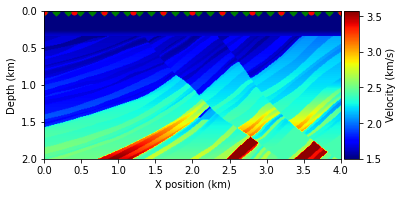

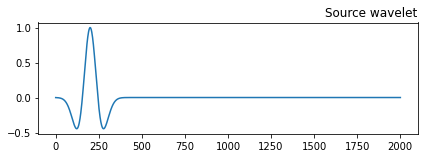

In [21]:
#set source number = 11, and receiver number = 101
nsrc=11; nrcv=101;

#set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nsrc)
src_loc[:, 1] = 20.

#set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 20.

t0 = 0.     # Shot records starts at 0.0
tn = 2000.  # Shot records last 2.0 second (2000 ms)
f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

# Plot acquisition geometry overlaid with true Vp, and source wavelet
from examples.seismic.plotting import plot_velocity
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.subplot(2,1,1); plot_velocity(model, source=src_loc, receiver=rcv_loc[::4]); # Plot every one in four receivers.
plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plt.subplot(2,1,2); plt.plot(geom_all.src.time_values, geom_all.src.data[:, 0])
plt.title('Source wavelet', loc='right')
plt.tight_layout(); plt.show()

## Forward model true shot records with the true velocity model

We pick a specific source number and run forward modeling for demonstration. In this case `isrc=3`, but it can be any number between 1 and 11. For this particular source, we run forward modeling twice, one with original/true Vp ("model") and the other with smooth/initial Vp ("model0"). The forward modeling outputs modeled shot data "record" and "record0", respectively. We plot four figures: acquisition geometry with this particular source, shot record from original/ture Vp, shot record from smooth/initial Vp, and their difference. The shot record difference is used to derive FWI gradient.

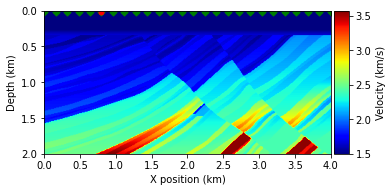

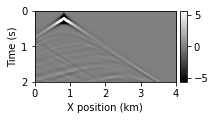

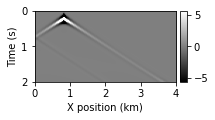

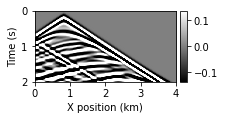

In [22]:
#Pick one source number
isrc = 3
geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
                               t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model, geometry, space_order=4)

#Define forward modeling of one source
def modeling_1src(vp_in):    
    # Create symbols to hold the data
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    # Generate modeled data from true model
    _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
    # Compute modeled data and full forward wavefield u0 from smooth model
    _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
    return d_obs, d_syn

#Genearte modeled shot data of both true and smooth velocity models
record, record0 = modeling_1src(model0.vp)

#Plot acquisition geometry and modeled shot data
from examples.seismic.plotting import plot_velocity, plot_shotrecord
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.subplot(2,2,1); plot_velocity(model, source=src_loc[isrc-1:isrc,:], receiver=rcv_loc[::4]);
plt.title('Acquisition geometry (1 shot)', loc='right')
plt.subplot(2,2,2); plot_shotrecord(record.data, model, t0, tn)
plt.title('Shot record - true vel', loc='right')
plt.subplot(2,2,3); plot_shotrecord(record0.data, model, t0, tn)
plt.title('Shot record - smooth vel', loc='right')
plt.subplot(2,2,4); plot_shotrecord(record0.data - record.data, model, t0, tn)
plt.show()

## Run 2D FWI with the modeled true shot records and the initial velocity model

### Define FWI Gradient Operator
To compute a single FWI gradient in our workflow, we again use `solver.forward` to compute the entire forward wavefield `u` and a similar pre-defined operator to compute the adjoint wavefield v. The gradient operator provided by our solver utility also computes the correlation between the two wavefields u and v, allowing us to derive the FWI gradient. Those three steps that derive the FWI gradient for a particular source are listed below. This procedure is applied to multiple sources and summed to obtain a FWI gradient image of the subsurface. 
* Simulate the forward wavefield u with the background velocity model to obtain the modeled data and save u
* Compute the data residual between the modeled data and true data
* Back-propagate the data residual to derive the wavefield v, and correlate v with the saved wavefield u to compute on the fly the FWI gradient at each time step which will be summed

In [23]:

# This cell contains some functions needed by our FWI algorithm/

# Function to compute the residual between true/observed and modeled/synthetic data
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # Compute the residual via a difference operator for MPI
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual



# Function to create FWI gradient kernel 
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]
        # Generate true data "d_obs" from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)
        # Update objective function 
        objective += .5 * norm(residual)**2
        # Derive FWI gradient "grad" 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    return objective, grad

# Function to perform the gradient decent update (with box constraints)
from sympy import Min, Max
def update_with_box(vp, alpha, direction, vmin=1.5, vmax=4.7):
    """
    Apply gradient update in-place to vp with box constraint
    """
    update = vp + alpha * direction
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [24]:
from numpy import linalg as la
# Add simple line search function here
# Define line search parameters
# initial_slop = -np.dot(direction.data,direction.data.T).sum()
def simple_line_search(max_search_iter=100):
    """Simple line search that halves lambda until the Armijo rule is satisfied
    """
    lamda = 0.0005 # Use initial .05/mmax(direction)
    num = 0
    history = np.zeros((max_search_iter, 1))
    current = np.zeros((max_search_iter, 1))
    for i in range(max_search_iter):
        history[i],dir = fwi_gradient(model0.vp)
        update_with_box(model0.vp, lamda, dir)
        current[i], _ = fwi_gradient(model0.vp)
        initial_slope = np.abs(1e-4*lamda*la.norm(np.dot(dir.data,np.transpose(dir.data))))
        print(np.abs(current[i] - history[i]))
        print(initial_slope)
        
        if np.abs(current[i] - history[i]) <= initial_slope:
            print('end search')
            break
        num = i+1
        lamda /= 2.     
    print("get alpha at search iter:", num)
    return current[i], lamda, i

Below we define our FWI iteration loop. The value of alpha is currently undefined and hence this cell wont currently run!

In [25]:
import time # For timing puposes only
from devito import mmax


fwi_start = time.time()

# Run FWI with gradient descent
fwi_iterations = 10
for j in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    
    
    obj, alpha, i = simple_line_search()
    
    
    
    # Log the progress of objective function value
    print('Objective value is %11.1f   at iteration %3d with alpha = %.16f' % (obj, i+1, alpha))
    
fwi_end = time.time()
print('Total FWI runtime (min):', (fwi_end-fwi_start)/60.0)
print('FWI runtime (min) per iteration:', (fwi_end-fwi_start)/60.0/float(fwi_iterations))

[29163.53703389]
6.301034800000001
[6335.66280451]
0.8916058000000001
[2049.46478869]
0.22828620000000002
[831.45325257]
0.08466227500000001
[395.23972135]
0.04026008750000001
[193.24734886]
0.019679837500000002
[95.49278917]
0.0097339453125
[47.4962487]
0.004841234765625001
[23.6102226]
0.0024142583984375003
[11.9217098]
0.0012055484375
[6.01020318]
0.0006023865722656251
[2.8619874]
0.0003010909423828125
[1.41426525]
0.000150521923828125
[0.79923385]
7.525514526367188e-05
[0.46297573]
3.762597351074219e-05
[0.18465354]
1.8812495422363282e-05
[0.05807524]
9.406148529052734e-06
[0.13245143]
4.703108978271485e-06
[0.10757077]
2.3515159606933597e-06
[0.078665]
1.175770378112793e-06
[0.00150946]
5.878840923309327e-07
[0.]
2.939417123794556e-07
end search
get alpha at search iter: 21
Objective value is     28816.0   at iteration  22 with alpha = 0.0000000002384186
[5281.40506324]
0.61644045
[1860.40499413]
0.21478337500000003
[824.31430778]
0.09956670625000001
[390.20334618]
0.046968996875


Below are some cells to check the result:

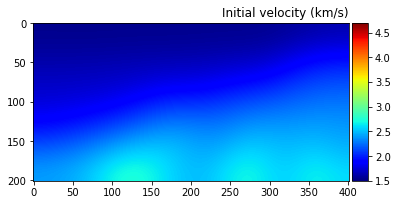

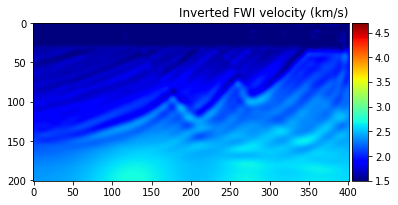

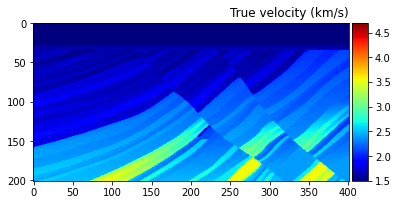

In [29]:
from examples.seismic import plot_image

# Plot initial/smooth velocity model
plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")

# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.5, vmax=4.7, cmap="jet")

# Plot True velocity model
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")

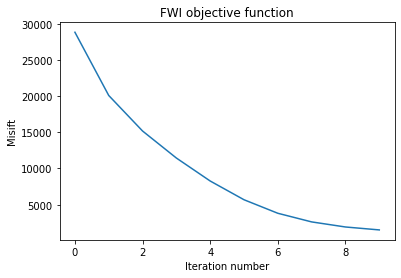

In [31]:
# plot objective function
obj_val = np.array([28816.0, 20082.3, 15176.9, 11444.2, 8270.7,
                    5683.0, 3815.4, 2622.6, 1920.9, 1516.3 ])
plt.plot(obj_val)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

## Part 1  - solution

#### (a) Discuss the true and original `m0` shot records (and their differences) here

True model image reflects : 
Generally, the signal behaves like a "^", which indicates, a certain receiver between [0,2] receives the signal first .
Vertically, the strength of the signal will fade as t increases.  

Initial smoothed model image resembles the image of true model only at the border:
Receivers only receives signal once, then no signals afterwards.

Difference image reflects that diffence of the signal strength, which will be used to compute the initial misfit 

#### (b) Discuss the values of `alpha` over which we see convergence here

According to the note in lecture 8, alpha = 0.05/max(grad) = 0.0005 would be a good choice to make algorithm converge.

    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    //alpha = .05 / mmax(direction)//

<img src="fig1.jpeg"/>

We hope the residual is stricktly decreasing for each iteration. We also hope the algorithm to work efficiently. Therefore, a detailed range for alpha would be 


If alpha is too small, the convergence will be slow,computational cost would increase and may risk getting stuck in local minima. If alpha is too large, the algorithm may oscillate or diverge. Also,the sensitivity of the algorithm to alpha is higher when the condition number of the Hessian matrix is large. 

#### (c) Explain the implementation of your line search algorithm for finding `alpha` here

 In the code we use the <a class="definition" href="#definitions" id="Armijiorule">Armijio rule</a>,  relates the change in $f$ to the expected change based on a linearisation of $f$:

$$
   f({\bf x}^{(i)} + \lambda{\bf p}^{(i)}) - f({\bf x}^{(i)}) \lt \alpha \lambda f'({\bf x}^{(i)})^T {\bf p}^{(i)}
$$

In the code we set $\alpha$ as defalut ($10^{-4}$),f is our objective function, which can be obtained by using **fwi_gradient** and we will use **update_with_box** to calculate **direction** and $f({\bf x}^{(i)} + \lambda{\bf p}^{(i)})$. $\lambda$ is the value of 'alpha' we want to sarch. The norm of the direction matrix will be used to calculate initial_slope.

 The line search algorithm starts with alpha = alpha_max and repeatedly applies the contraction rule until the Armijo condition is satisfied. This condition ensures that the function value at the new iterate is sufficiently decreased relative to the predicted decrease based on the gradient and step size.

Once the optimal alpha value is found, it is used to update the current iterate x by x = x0 + alpha*p. This process can be repeated at each iteration of the FWI algorithm to determine the optimal step size for that iteration.